It is worth noting that this part is similar to part 1 (1_GLT1_GS_graph_stat), in particulat it is similar to GS-analysis part.

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp

import matplotlib.ticker as ticker
from statannot import add_stat_annotation

In [2]:
def csv_to_xlsx_cell():
    csv_search_string = 'data3/*GFAP*.csv'
    csv_filepaths = glob.glob(csv_search_string)
    df = pd.DataFrame()
    for csv in csv_filepaths:
        out = csv.split('.')[0]+'.xlsx'
        df = pd.read_csv(csv, sep=',', decimal = '.', encoding='latin1',engine='python')
        df = df.to_excel(out, float_format="%.4f")
    return (df)
#csv_to_xlsx_cell()

In [3]:
def file_extraction(search_string): 
    filepaths = glob.glob(search_string) 
    df = pd.DataFrame()
    col_name_suffix = 1
    for find_files in filepaths:
        df = df.join (pd.read_excel(find_files, usecols=[2,5]), how='outer',lsuffix=col_name_suffix, )
        col_name_suffix +=1 
    return(df)

In [4]:
N1_cell_vol_ctrl = file_extraction('data3/N1*_ctrl_*_GFAP.xlsx').sum().iloc[::2]
N2_cell_vol_ctrl = file_extraction('data3/N2*_ctrl_*_GFAP.xlsx').sum().iloc[::2]
N3_cell_vol_ctrl = file_extraction('data3/N3*_ctrl_*_GFAP.xlsx').sum().iloc[::2]
N5_cell_vol_ctrl = file_extraction('data3/N5*_ctrl_*_GFAP.xlsx').sum().iloc[::2]

N1_cell_vol_SE = file_extraction('data3/N1*SE*_GFAP.xlsx').sum().iloc[::2]
N2_cell_vol_SE = file_extraction('data3/N2*SE*_GFAP.xlsx').sum().iloc[::2]
N4_cell_vol_SE = file_extraction('data3/N4*SE*_GFAP.xlsx').sum().iloc[::2]
N5_cell_vol_SE = file_extraction('data3/N5*SE*_GFAP.xlsx').sum().iloc[::2]
N6_cell_vol_SE = file_extraction('data3/N6*SE*_GFAP.xlsx').sum().iloc[::2]

In [5]:
df_tot_vol = pd.read_excel('data3/total_vol_gfap_glt.xlsx')

In [6]:
all_cell_vol_ctrl = pd.concat([N1_cell_vol_ctrl,N2_cell_vol_ctrl,N3_cell_vol_ctrl, N5_cell_vol_ctrl ])
all_cell_vol_SE = pd.concat([N1_cell_vol_SE,N2_cell_vol_SE,N4_cell_vol_SE,N5_cell_vol_SE,N6_cell_vol_SE])

all_cell_vol = pd.DataFrame()
all_cell_vol ['Контроль'] = (all_cell_vol_ctrl/df_tot_vol.iloc[:, 2].dropna().values)
all_cell_vol.reset_index(inplace=True, drop=True)
all_cell_vol = all_cell_vol.join(pd.DataFrame((all_cell_vol_SE.values/df_tot_vol.iloc[:, 3].dropna().values)), how= 'outer')
all_cell_vol.rename(columns = {0 : 'ЭС'}, inplace = True)

all_cell_vol.drop(all_cell_vol[all_cell_vol['ЭС']> 0.25].index, inplace=True)#удалим выбросы

In [7]:
percentile_cell_vol = all_cell_vol.quantile([0.25, 0.50 , 0.75])
print(percentile_cell_vol)
stat_cell_vol, p_cell_vol = mannwhitneyu(all_cell_vol.iloc[:, 0].dropna(), all_cell_vol.iloc[:, 1].dropna())
print('Statistics=%.3f, p=%.4f' % (stat_cell_vol, p_cell_vol))

      Контроль        ЭС
0.25  0.048756  0.076835
0.50  0.070618  0.108870
0.75  0.094538  0.152611
Statistics=107.000, p=0.0182


In [8]:
def boxplot_graph(data, dots, fig_name, big_tick, ylim): 
    plt.figure(figsize=(6,8)) # меняет размер графика
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(font_scale=1.5, style="ticks",context="poster", rc= custom_params)
    plot = sns.boxplot(data = data, palette="vlag", fliersize = 0, linewidth = 7)
    plot.set_ylabel(fig_name)
    plot.spines['left'].set_linewidth(4)
    plot.spines['bottom'].set_linewidth(4)
    plot.yaxis.set_major_locator(ticker.MultipleLocator(big_tick))
    plt.ylim(ylim)
    add_stat_annotation(plot, data=data,
                    box_pairs=[("Контроль", "ЭС")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=1, comparisons_correction=None, linewidth=4)
    fig_name = 'figs/GFAP_GLT1/' + fig_name + '.tif'
    plot = plot.get_figure()
    plt.tight_layout() 
    if dots == True:
        sns.stripplot(data=data,
              size=17, linewidth=4,palette = "Set2", jitter = True)
    plot.savefig(fig_name, dpi=1200)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Контроль v.s. ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.821e-02 U_stat=1.070e+02


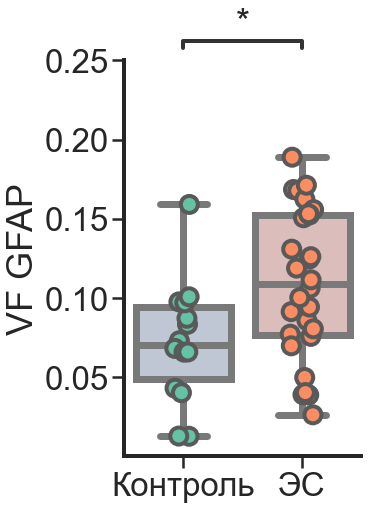

In [9]:
boxplot_graph(all_cell_vol, dots = True, fig_name= 'VF GFAP', big_tick = 0.05, ylim = [0.0001, 0.25])

In [10]:
def df_perc_stack (df_list,name_list):
    df = pd.DataFrame()
    
    for i in range (len(name_list)):
        name_id = name_list[i]
        index = pd.MultiIndex.from_product([[name_id ], [0.25, 0.50, 0.75]], 
                                                    names = ['Type', 'Percintile'])
        if i==0:
            df = pd.DataFrame(index=index, data=df_list[0].values,
                                            columns=['Контроль','ЭС'])
        else:
            df = pd.concat([df, pd.DataFrame(index=index, data=df_list[i].values,
                                            columns=['Контроль','ЭС'])])
    return df

perc_list = [percentile_cell_vol ]
perc_name_list = ['GFAP_vol']

perc_table_final = df_perc_stack (perc_list,perc_name_list)

In [11]:
def df_stat_stack(df_p_list, df_stat_list, name_list):
    df = pd.DataFrame()
    for i in range (len(name_list)):
        name_id = name_list[i]
        index = pd.MultiIndex.from_product([[name_id ],['P-val', 'MW(U)']], 
                                                    names = ['Type', 'Stats'])
        if i==0:
            df = pd.DataFrame(index=index, data=[df_p_list[0], df_stat_list[0]],
                                            columns=['Value'])
        else:
            df = pd.concat([df, pd.DataFrame(index=index, data=[df_p_list[i], df_stat_list[i]],
                                            columns=['Value'])])
    return(df)

df_p_list = [p_cell_vol]
name_p_list = ['p_cell_vol']
df_stat_list = [stat_cell_vol]

stat_table_final = df_stat_stack(df_p_list,df_stat_list, name_p_list)

In [12]:
stat_table_final

Value
Type       Stats           
p_cell_vol P-val    0.01821
           MW(U)  107.00000

In [13]:
with pd.ExcelWriter('output_table/final_out_gfap_glt.xlsx') as writer:  
    perc_table_final.to_excel(writer, sheet_name='Percentiles', float_format="%.3f")
    stat_table_final.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.9f")